In [ ]:
# AlexNet Implementation for https://www.notion.so/AlexNet-cff9b236e80d4196916a306d1ae86e17

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm


In [ ]:
# load dataset, used cifar-10 here since ILSVRC is not easily accessible right now
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
# (train_images, train_labels), (test_images, test_labels) = (train_images.astype(np.float), train_labels.astype(np.float)), (test_images.astype(np.float), test_labels.astype(np.float))

170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
# TRAINING CONFIG
batch_size = 128

In [ ]:
def augment_fn(image, label):
  """
  augmentation function used in dataset pipeline
  """
  image = image / 255
  image = tf.image.resize(image, [256, 256])
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_crop(image, [224, 224, 3])

  # label sparse to categorical
  label = tf.one_hot(tf.squeeze(label), depth=10)

  return (image, label)

def preprocess_no_aug(image, label):
  """
  preprocessing function used in test dataset pipeline, no augmentation
  """
  image = image / 255
  image = tf.image.resize(image, [224, 224])

  # label sparse to categorical
  label = tf.one_hot(tf.squeeze(label), depth=10)

  return (image, label)

In [ ]:
# Use tf.data pipeline

# split 10% to validation
split = int(0.1 * len(train_images))
valid_images = train_images[:split]
train_images = train_images[split:]

valid_labels = train_labels[:split]
train_labels = train_labels[split:]


# Train set
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = (
    train_ds
    .map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
    # .cache()
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Validation set
valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))
valid_ds = (
    valid_ds
    .map(preprocess_no_aug, num_parallel_calls=tf.data.AUTOTUNE)
    # .cache()
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Test set
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = (
    test_ds
    .map(preprocess_no_aug, num_parallel_calls=tf.data.AUTOTUNE)
    # .cache()
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# test_x = test_ds.as_numpy_iterator()
# print(list(test_x))

In [ ]:
# def resize_images(images, target):
#   """
#   resize N images
#   input:
#     - images: an array of images, must in 4D (N, H, W, C)
#     - target: a 2d tuple specifying target size
#   output:
#     - inplace resize a 4D numpy array of images
#   """
#   for i, img in enumerate(tqdm(images)):
#     images[i] = cv2.resize(img, dsize=target)


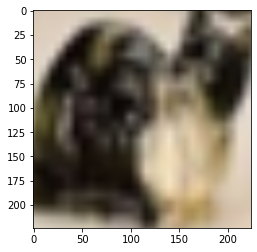

In [ ]:
%matplotlib inline
sample_ds = train_ds.shuffle(10).take(1).as_numpy_iterator()
it = iter(sample_ds)
fig, axes = plt.subplots()
axes = plt.imshow(it.next()[0][0])
plt.show()

In [ ]:
# data info
print("RAW IMAGES:")
print("Shape of train images: {}".format(train_images.shape))
print("Shape of train labels: {}".format(train_labels.shape))
print("Shape of test images: {}".format(test_images.shape))
print("Shape of test labels: {}".format(test_labels.shape))
print("Data type: ", train_images.dtype)

print("TF DATASET: ")
for image, label in train_ds:
  print(image.shape)
  print(label.shape)
  break
# print("Shape of 1 batch train dataset: {}".format())


RAW IMAGES:
Shape of train images: (45000, 32, 32, 3)
Shape of train labels: (45000, 1)
Shape of test images: (10000, 32, 32, 3)
Shape of test labels: (10000, 1)
Data type:  uint8
TF DATASET: 
(128, 224, 224, 3)
(128, 10)


In [ ]:
# # USE Keras' ImageDataGenerator for loading data and training
# def center_crop(image, ) -> np.ndarray:
#   """
#   custom center crop function, used in tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=)
#   input: 
#     - image: a single image (numpy tensor with rank 3)
#     - crop_size: a tuple of height and width, specifying the height and width randomly cropped
#   output - a new numpy tensor with same shape
#   """
#   pass


# # ImageDataGenerator
# train_dataGen = ImageDataGenerator(
#     # rescale=1/255, # In alexnet paper, there is no rescale
#     # Data Augmentation
#     horizontal_flip=True
# )

# train_set = train_dataGen.flow(train_images, train_labels, batch_size=128)

In [ ]:
# network architecture
class AlexNet(tf.keras.Model):
  def __init__(self, num_classes=1000, input_shape=(224, 224, 3)):
    super(AlexNet, self).__init__()
    # 1st conv layer
    self.conv_1 = Conv2D(96, (11,11), strides=(4,4), activation='relu', input_shape=input_shape)
    self.bn_1 = BatchNormalization()
    self.max_1 = MaxPooling2D((3,3), strides=(2,2)) # overlapping pooling described in the paper

    # 2nd conv layer
    self.conv_2 = Conv2D(256, (5,5), activation='relu')
    self.bn_2 = BatchNormalization()
    self.max_2 = MaxPooling2D((3,3), strides=(2,2))

    # 3rd conv layer
    self.conv_3 = Conv2D(384, (3,3), activation='relu')

    # 4th conv layer
    self.conv_4 = Conv2D(384, (3,3), activation='relu')

    # 5th conv layer
    self.conv_5 = Conv2D(256, (3,3), activation='relu')
    self.max_5 = MaxPooling2D((3,3), strides=(2,2))

    # Flatten
    self.flatten = Flatten()

    # 1st fc layer
    self.fc_1 = Dense(4096, activation='relu')
    self.drop_1 = Dropout(0.5)

    # 2nd fc_layer
    self.fc_2 = Dense(4096, activation='relu')
    self.drop_2 = Dropout(0.5)

    # 3rd fc_layer (output layer)
    self.fc_3 = Dense(num_classes, activation='softmax')

  def call(self, inputs):
    """
    model's forward pass
    """
    # 1st conv
    x = self.conv_1(inputs)
    x = self.bn_1(x)
    x = self.max_1(x)
    
    # 2nd conv
    x = self.conv_2(x)
    x = self.bn_2(x)
    x = self.max_2(x)

    # 3rd conv
    x = self.conv_3(x)

    # 4th conv
    x = self.conv_4(x)

    # 5th conv
    x = self.conv_5(x)
    x = self.max_5(x)

    x = self.flatten(x)

    # 1st fc
    x = self.fc_1(x)
    x = self.drop_1(x)

    # 2nd fc
    x = self.fc_2(x)
    x = self.drop_2(x)

    # 3rd fc: output layer
    x = self.fc_3(x)
    return x


In [ ]:
def train(epochs=90):
  """
  train AlexNet
  """
  model = AlexNet(num_classes=10)
  # display model info
  model.build((None, 224, 224, 3))
  model.summary()

  init_lr = 0.01
  decay_steps = 10000
  decay_rate = 0.96
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=init_lr, decay_steps=decay_steps, decay_rate=decay_rate)

  optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(
      x=train_ds,
      validation_data=valid_ds,
      epochs=epochs,
  )
  return history, model


In [ ]:
# Train networks
history, model = train(epochs=90)

Model: "alex_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            multiple                  34944     
_________________________________________________________________
batch_normalization_2 (Batch multiple                  384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_6 (Conv2D)            multiple                  614656    
_________________________________________________________________
batch_normalization_3 (Batch multiple                  1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_7 (Conv2D)            multiple                  8

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(
    test_ds
)

# Plot accuracy -> epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()